In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt

In [2]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [3]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/mushrooms_small.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content")

In [4]:
class MushroomDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""
    def __init__(self, root_dir, transform=None, target_size=None):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Первичная аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Получаем список классов (папок)
        self.ediable_cls = sorted([d for d in os.listdir(root_dir)   if os.path.isdir(os.path.join(root_dir, d))])
        self.ediable2idx = {cls_name: idx for idx, cls_name in enumerate(self.ediable_cls)}

        self.mushroom_cls = [os.listdir(os.path.join(root_dir, dir_name)) for dir_name in self.ediable_cls]
        self.mushroom_cls = [d for mushdir in self.mushroom_cls for d in mushdir]
        self.mushroom2idx = {cls_name: idx for idx, cls_name in enumerate(self.mushroom_cls)}


        # Собираем все пути к изображениям
        self.images = []
        self.labels: list[dict] = []

        for ed_name in self.ediable_cls:
            ediable_dir = os.path.join(root_dir, ed_name)
            ediable_id = self.ediable2idx[ed_name]

            for mush_name in os.listdir(ediable_dir):
                class_dir = os.path.join(ediable_dir, mush_name)
                mush_id = self.mushroom2idx[mush_name]

                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        img_path = os.path.join(class_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append({'ed_id': ediable_id,
                                            'mush_id': mush_id})


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Ресайзим изображение
        if self.target_size:
            image = image.resize(self.target_size, Image.Resampling.LANCZOS)

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        # image = image.view()

        '''СТАВИМ ТОЛЬКО!!! ed_id '''
        return image, label['ed_id']

    def get_mushrooms_name(self):
        """Возвращает список имен видов грибов"""
        return self.mushroom_cls

    def get_ediable_name(self):
        """Возвращает список о съедобности"""
        return self.ediable_cls

In [5]:
def get_sinusoid_encoding(num_tokens, token_len):
    """ Make Sinusoid Encoding Table

        Args:
            num_tokens (int): number of tokens
            token_len (int): length of a token

        Returns:
            (torch.FloatTensor) sinusoidal position encoding table
    """

    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class NeuralNet(nn.Module):
    def __init__(self,
       in_chan: int,
       hidden_chan =None,
       out_chan =None,
       act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class Encoding(nn.Module):
    def __init__(self,
       dim: int,
       num_heads: int=1,
       hidden_chan_mul: float=4.,
       qkv_bias: bool=False,
       qk_scale =None,
       act_layer=nn.GELU,
       norm_layer=nn.LayerNorm):

        """ Encoding Block

            Args:
                dim (int): size of a single token
                num_heads(int): number of attention heads in MSA
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by;
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim=dim,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        self.neuralnet = NeuralNet(in_chan=dim,
                                hidden_chan=int(dim*hidden_chan_mul),
                                out_chan=dim,
                                act_layer=act_layer)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

class Patch_Tokenization(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(3, 224, 244),
                patch_size: int=16,
                token_len: int=768,
                batch: int = 32):

        """ Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = int((H / self.patch_size) * (W / self.patch_size))

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        print(x.size())
        x = self.split(x).transpose(1,2)
        print(x.size())
        x = self.project(x)
        # print(x, '\n', x.size())
        return x

class ViT_Backbone(nn.Module):
    def __init__(self,
                num_tokens,
                preds: int=1,
                token_len: int=768,
                num_heads: int=4,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Backbone
            Args:
                preds (int): number of predictions to output
                token_len (int): length of a token
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by;
                 if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth
        self.token_len = token_len
        self.num_tokens = num_tokens

        ## Defining Token Processing Components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        # self.cls_token = torch.transpose(self.cls_token, 0, 1)
        self.pos_embed = nn.Parameter(data=get_sinusoid_encoding(num_tokens=self.num_tokens+1, token_len=self.token_len), requires_grad=False)

        ## Defining Encoding blocks
        self.blocks = nn.ModuleList([Encoding(dim = self.token_len,
                                               num_heads = self.num_heads,
                                               hidden_chan_mul = self.Encoding_hidden_chan_mul,
                                               qkv_bias = qkv_bias,
                                               qk_scale = qk_scale,
                                               act_layer = act_layer,
                                               norm_layer = norm_layer)
             for i in range(self.depth)])

        ## Defining Prediction Processing
        self.norm = norm_layer(self.token_len)
        self.head = nn.Linear(self.token_len, preds)

        ## Make the class token sampled from a truncated normal distrobution
        timm.layers.trunc_normal_(self.cls_token, std=.02)

    def forward(self, x):
        ## Assumes x is already tokenized

        ## Get Batch Size
        B = x.shape[0]
        ## Concatenate Class Token
        print(x.size())
        # print(self.cls_token.expand(B, -1, -1))
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1)
        print(x.size())
        print(self.cls_token.size())
        # x = torch.transpose(x, 0, 1)
        # x = torch.cat((self.cls_token, x), dim=1)
        # x = torch.transpose(x, 0, 1)
        ## Add Positional Embedding
        x = x + self.pos_embed
        ## Run Through Encoding Blocks
        for blk in self.blocks:
            x = blk(x)
        ## Take Norm
        x = self.norm(x)
        ## Make Prediction on Class Token
        x = self.head(x[:, 0])
        return x

class MushroomViTModel(nn.Module):
    def __init__(self,
        img_size: tuple[int, int, int]=(3, 224, 224),
        patch_size: int=16,
        token_len: int=768,
        preds: int=4,
        num_heads: int=1,
        Encoding_hidden_chan_mul: float=4.,
        depth: int=12,
        qkv_bias=False,
        qk_scale=None,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm):

      """ VisTransformer Model

      Args:
        img_size (tuple[int, int, int]): size of input (channels, height, width)
        patch_size (int): the side length of a square patch
        token_len (int): desired length of an output token
        preds (int): number of predictions to output
        num_heads(int): number of attention heads in MSA
        Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
        depth (int): number of encoding blocks in the model
        qkv_bias (bool): determines if the qkv layer learns an addative bias
        qk_scale (NoneFloat): value to scale the queries and keys by;
            if None, queries and keys are scaled by ``head_dim ** -0.5``
        act_layer(nn.modules.activation): torch neural network layer class to use as activation
        norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
      """
      super().__init__()

      ## Defining Parameters
      self.img_size = img_size
      C, H, W = self.img_size
      self.patch_size = patch_size
      self.token_len = token_len
      self.num_heads = num_heads
      self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
      self.depth = depth

      ## Defining Patch Embedding Module
      self.patch_tokens = Patch_Tokenization(img_size,
              patch_size,
              token_len)
      self.num_tokens = self.patch_tokens.num_tokens

      ## Defining ViT Backbone
      self.backbone = ViT_Backbone(self.num_tokens,
            preds,
            self.token_len,
            self.num_heads,
            self.Encoding_hidden_chan_mul,
            self.depth,
            qkv_bias,
            qk_scale,
            act_layer,
            norm_layer)
      ## Initialize the Weights
      self.apply(self._init_weights)

    def _init_weights(self, m):
      """ Initialize the weights of the linear layers & the layernorms
      """
      ## For Linear Layers
      if isinstance(m, nn.Linear):
        ## Weights are initialized from a truncated normal distrobution
        timm.layers.trunc_normal_(m.weight, std=.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
          ## If bias is present, bias is initialized at zero
          nn.init.constant_(m.bias, 0)
      ## For Layernorm Layers
      elif isinstance(m, nn.LayerNorm):
        ## Weights are initialized at one
        nn.init.constant_(m.weight, 1.0)
        ## Bias is initialized at zero
        nn.init.constant_(m.bias, 0)

    @torch.jit.ignore ##Tell pytorch to not compile as TorchScript
    def no_weight_decay(self):
      """ Used in Optimizer to ignore weight decay in the class token
      """
      return {'cls_token'}

    def forward(self, x):
      batch_size = x.shape[0]
      x = self.patch_tokens(x)
      x = self.backbone(x)
      return x

In [6]:
# Загрузка датасета без аугментаций с преобразованием PIL --> torch.tensor()
transform = transforms.ToTensor()

root_train = '/content/mushroom_dataset/'
data = MushroomDataset(root_train, transform=transform, target_size=(224, 224))

In [7]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    # Переносим модель на устройство
    model.to(device)

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        print(data.size(), target.size())
        # output = torch.tensor([])
        # loss = torch.tensor([])
        # for img, label in  enumerate((data, target)):
        #     output_img = model(img)
        #     loss_img = criterion(output_img, label)
        #     output.append(output_img)
        #     loss.append(loss_img)
        output = model(data)
        print(output, output.size())
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model:nn.Module, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    # Поробуем SGD
    optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.9, weight_decay=0.0002)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accs': train_accs,
                'test_losses': test_losses,
                'test_accs': test_accs
            }, f'compactCNN_last_checkpoit.pt')


        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': test_loss,
                'accuracy': test_acc
            }, f'compactCNN_best_model.pt')


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [8]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Делим на train, test выборки
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
mushroom_vit = MushroomViTModel()

metric_vit = train_model(mushroom_vit, train_loader, test_loader, epochs=20, lr=0.0005, device='cuda:0')

  0%|          | 0/20 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-0.6995,  1.7652, -2.3039,  2.3162],
        [-0.7620,  1.8065, -2.3512,  2.3419],
        [-0.7405,  1.7923, -2.3342,  2.3331],
        [-0.8098,  1.8413, -2.3841,  2.3636],
        [-0.7991,  1.8325, -2.3765,  2.3582],
        [-0.7713,  1.8158, -2.3562,  2.3479],
        [-0.7973,  1.8302, -2.3766,  2.3565],
        [-0.7742,  1.8147, -2.3593,  2.3471],
        [-0.8103,  1.8392, -2.3848,  2.3624],
        [-0.7397,  1.7940, -2.3322,  2.3345],
        [-0.8886,  1.8911, -2.4396,  2.3932],
        [-0.7791,  1.8185, -2.3627,  2.3496],
        [-0.7103,  1.7704, -2.3118,  2.3192],
        [-0.8112,  1.8414, -2.3849,  2.3640],
        [-0.7579,  1.8051, -2.3477,  2.3411],
        [-0.7061,  1.7689, -2.3080,  2.3186],
        [-0.8016,  1.8346, -2.3781,  2.3595],
        [-0.7046,  1.7660, -2.3092,  2.3162],
        [-0.7756,  1.8193, -2.3599,  2.3497],
        [-0.7307,  1.7851, -2.3273,  2.3286],
        [-0.

  5%|▌         | 1/20 [04:08<1:18:39, 248.39s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.3540, -0.3561,  0.9054,  0.8514],
        [-1.3338, -0.3714,  0.9144,  0.8273],
        [-0.9490, -0.5892,  1.2646,  0.4618],
        [-1.2752, -0.4021,  0.9704,  0.7761],
        [-1.1515, -0.4715,  1.0834,  0.6596],
        [-1.2679, -0.4067,  0.9855,  0.7675],
        [-1.1663, -0.4701,  1.0683,  0.6669],
        [-1.4545, -0.2980,  0.8150,  0.9443],
        [-1.3623, -0.3463,  0.8899,  0.8635],
        [-0.9451, -0.5869,  1.2866,  0.4635],
        [-1.3889, -0.3308,  0.8682,  0.8873],
        [-1.6743, -0.1666,  0.6229,  1.1488],
        [-1.1676, -0.4635,  1.0646,  0.6737],
        [-1.3585, -0.3527,  0.8922,  0.8547],
        [-0.9934, -0.5649,  1.2272,  0.5050],
        [-1.0239, -0.5438,  1.1940,  0.5375],
        [-1.2528, -0.4131,  0.9834,  0.7569],
        [-1.2842, -0.3995,  0.9559,  0.7819],
        [-0.7481, -0.7002,  1.4680,  0.2672],
        [-1.3217, -0.3735,  0.9235,  0.8213],
        [-1.

 10%|█         | 2/20 [08:21<1:15:25, 251.41s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.9983,  0.4736, -0.0429,  1.3508],
        [-1.8334,  0.2528,  0.1500,  1.2808],
        [-1.8240,  0.2416,  0.1605,  1.2761],
        [-1.8667,  0.2906,  0.1139,  1.2914],
        [-1.5942, -0.0543,  0.4305,  1.1736],
        [-1.9896,  0.4520, -0.0335,  1.3420],
        [-1.5034, -0.1682,  0.5426,  1.1339],
        [-1.9160,  0.3605,  0.0506,  1.3158],
        [-1.7527,  0.1447,  0.2452,  1.2430],
        [-2.0386,  0.5216, -0.0947,  1.3636],
        [-1.6851,  0.0596,  0.3219,  1.2136],
        [-1.7536,  0.1466,  0.2508,  1.2458],
        [-1.8026,  0.2124,  0.1873,  1.2680],
        [-1.5853, -0.0683,  0.4423,  1.1686],
        [-1.5133, -0.1591,  0.5389,  1.1368],
        [-1.3726, -0.3328,  0.7005,  1.0703],
        [-1.9945,  0.4609, -0.0388,  1.3452],
        [-1.9891,  0.4549, -0.0304,  1.3442],
        [-1.5445, -0.1099,  0.4920,  1.1571],
        [-1.4524, -0.2347,  0.6097,  1.1091],
        [-1.

 15%|█▌        | 3/20 [12:31<1:10:58, 250.51s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-0.9781, -0.2777,  0.6775,  0.6543],
        [-1.6317,  0.1942,  0.1243,  1.0568],
        [-1.3452, -0.0182,  0.3745,  0.8789],
        [-1.1828, -0.1323,  0.5134,  0.7783],
        [-1.0095, -0.2449,  0.6476,  0.6737],
        [-1.0418, -0.2363,  0.6224,  0.6892],
        [-1.3092, -0.0438,  0.4009,  0.8554],
        [-1.5380,  0.1264,  0.2125,  1.0019],
        [-1.3141, -0.0400,  0.3984,  0.8596],
        [-1.0880, -0.2012,  0.5809,  0.7155],
        [-1.0606, -0.2105,  0.6136,  0.7054],
        [-1.4988,  0.0929,  0.2395,  0.9752],
        [-1.6104,  0.1781,  0.1466,  1.0469],
        [-1.5708,  0.1458,  0.1749,  1.0193],
        [-1.4005,  0.0241,  0.3291,  0.9118],
        [-1.3102, -0.0436,  0.3967,  0.8523],
        [-1.1568, -0.1515,  0.5255,  0.7614],
        [-1.1302, -0.1717,  0.5426,  0.7431],
        [-1.1959, -0.1216,  0.4984,  0.7866],
        [-1.1566, -0.1558,  0.5232,  0.7544],
        [-1.

 20%|██        | 4/20 [16:46<1:07:20, 252.53s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.4640, -0.1095,  0.2296,  1.1701],
        [-1.1795, -0.3018,  0.4816,  0.9800],
        [-1.4314, -0.1354,  0.2586,  1.1428],
        [-1.0750, -0.3732,  0.5648,  0.9089],
        [-1.1050, -0.3575,  0.5368,  0.9252],
        [-1.1416, -0.3267,  0.5041,  0.9540],
        [-1.1925, -0.2943,  0.4585,  0.9855],
        [-1.2399, -0.2600,  0.4189,  1.0248],
        [-1.0971, -0.3536,  0.5531,  0.9240],
        [-0.9227, -0.4721,  0.6887,  0.7894],
        [-0.9402, -0.4634,  0.6842,  0.8061],
        [-1.5208, -0.0761,  0.1790,  1.2009],
        [-1.0245, -0.4069,  0.5990,  0.8696],
        [-1.2708, -0.2414,  0.3885,  1.0406],
        [-1.4356, -0.1341,  0.2550,  1.1479],
        [-1.3229, -0.2091,  0.3502,  1.0783],
        [-1.4437, -0.1344,  0.2350,  1.1474],
        [-0.7114, -0.6088,  0.9376,  0.6341],
        [-1.0742, -0.3711,  0.5745,  0.9084],
        [-0.9871, -0.4241,  0.6505,  0.8503],
        [-1.

 25%|██▌       | 5/20 [21:05<1:03:41, 254.74s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.3076, -0.3073,  0.2903,  1.1704],
        [-1.4019, -0.2043,  0.2122,  1.2187],
        [-1.4075, -0.2023,  0.1979,  1.2201],
        [-1.6220,  0.0280, -0.0284,  1.3146],
        [-1.3074, -0.3006,  0.3048,  1.1741],
        [-1.0862, -0.5233,  0.5661,  1.0450],
        [-1.2139, -0.3978,  0.4003,  1.1137],
        [-1.1516, -0.4569,  0.4842,  1.0849],
        [-1.3595, -0.2521,  0.2449,  1.1951],
        [-1.0485, -0.5502,  0.5990,  1.0176],
        [-0.9914, -0.6099,  0.6810,  0.9840],
        [-0.6519, -0.9462,  1.2394,  0.6768],
        [-1.3958, -0.2172,  0.2062,  1.2123],
        [-1.2305, -0.3603,  0.4035,  1.1324],
        [-1.2875, -0.3279,  0.3227,  1.1615],
        [-1.5837, -0.0131,  0.0137,  1.2974],
        [-1.1655, -0.4380,  0.4625,  1.0945],
        [-1.3359, -0.2769,  0.2747,  1.1846],
        [-1.3352, -0.2740,  0.2777,  1.1802],
        [-1.1481, -0.4596,  0.4856,  1.0806],
        [-1.

 30%|███       | 6/20 [25:19<59:24, 254.58s/it]  

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.6569, -0.0743, -0.1809,  1.5882],
        [-1.2474, -0.2982,  0.2235,  1.1698],
        [-1.2293, -0.3113,  0.2362,  1.1463],
        [-1.1928, -0.3233,  0.3182,  1.0985],
        [-1.3943, -0.2154,  0.0893,  1.3206],
        [-1.6403, -0.0870, -0.1622,  1.5700],
        [-1.4151, -0.2121,  0.0491,  1.3377],
        [-1.2225, -0.3065,  0.2721,  1.1431],
        [-1.2510, -0.2948,  0.2196,  1.1775],
        [-1.0348, -0.4065,  0.4716,  0.9335],
        [-1.2523, -0.2941,  0.2241,  1.1729],
        [-1.7508, -0.0233, -0.2556,  1.6746],
        [-1.2755, -0.2828,  0.2000,  1.1981],
        [-1.1500, -0.3497,  0.3310,  1.0632],
        [-1.2684, -0.2819,  0.2258,  1.1942],
        [-1.2434, -0.2937,  0.2599,  1.1644],
        [-1.2125, -0.3165,  0.2583,  1.1301],
        [-1.2965, -0.2712,  0.1732,  1.2221],
        [-1.1105, -0.3627,  0.4030,  1.0235],
        [-1.1608, -0.3422,  0.3114,  1.0653],
        [-1.

 35%|███▌      | 7/20 [29:29<54:49, 253.06s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.6929, -0.1498,  0.5549,  1.2094],
        [-1.5188, -0.3227,  0.7467,  1.1249],
        [-1.6935, -0.1671,  0.5633,  1.2201],
        [-1.4856, -0.3726,  0.8198,  1.1166],
        [-1.6852, -0.1729,  0.5930,  1.2184],
        [-1.3692, -0.4856,  0.9983,  1.0333],
        [-1.5889, -0.2603,  0.6748,  1.1703],
        [-1.8191, -0.0358,  0.4357,  1.2664],
        [-1.8353, -0.0192,  0.4177,  1.2741],
        [-1.7553, -0.1175,  0.5428,  1.2394],
        [-1.5586, -0.2985,  0.6844,  1.1495],
        [-2.1099,  0.2695,  0.1583,  1.3718],
        [-1.6338, -0.2354,  0.6731,  1.1926],
        [-1.9761,  0.1151,  0.2952,  1.3291],
        [-1.6867, -0.1718,  0.5556,  1.2159],
        [-1.2362, -0.8177,  2.0023,  0.6810],
        [-1.5058, -0.3485,  0.8307,  1.1306],
        [-1.8371, -0.0141,  0.4084,  1.2759],
        [-1.7377, -0.1185,  0.5216,  1.2330],
        [-1.6781, -0.1758,  0.5645,  1.2102],
        [-1.

 40%|████      | 8/20 [33:38<50:20, 251.73s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.2486, -0.2967,  0.4024,  1.1195],
        [-1.3081, -0.2704,  0.3494,  1.1370],
        [-1.2661, -0.3013,  0.4018,  1.1258],
        [-1.1717, -0.3386,  0.4965,  1.0637],
        [-1.4560, -0.1528,  0.1847,  1.2004],
        [-1.1626, -0.3325,  0.4060,  1.0498],
        [-1.4043, -0.2143,  0.2449,  1.1774],
        [-1.1066, -0.3810,  0.5185,  1.0316],
        [-1.4636, -0.1523,  0.1793,  1.2051],
        [-1.2899, -0.2858,  0.4015,  1.1402],
        [-1.1602, -0.3636,  0.4829,  1.0666],
        [-1.3887, -0.1730,  0.1700,  1.1634],
        [-1.7138,  0.0708, -0.0499,  1.3062],
        [-0.9761, -0.3906,  0.7101,  0.8969],
        [-1.0311, -0.4013,  0.6199,  0.9552],
        [-1.5946, -0.0498,  0.0854,  1.2559],
        [-1.4409, -0.1833,  0.2075,  1.1897],
        [-1.5163, -0.1010,  0.1255,  1.2232],
        [-1.5424, -0.0810,  0.0863,  1.2343],
        [-1.3525, -0.2469,  0.3032,  1.1587],
        [-1.

 45%|████▌     | 9/20 [37:51<46:13, 252.12s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.4112, -0.2232,  0.2193,  1.2193],
        [-1.6297, -0.0363,  0.0113,  1.3810],
        [-1.0614, -0.5392,  0.6615,  0.9608],
        [-1.1105, -0.4912,  0.5427,  1.0136],
        [-1.5852, -0.0877,  0.0585,  1.3558],
        [-1.2861, -0.3423,  0.3531,  1.1445],
        [-0.7594, -0.7036,  0.7841,  0.7355],
        [-1.2476, -0.3865,  0.4184,  1.1105],
        [-1.4307, -0.2429,  0.2568,  1.2314],
        [-1.0680, -0.4509,  0.4568,  1.0027],
        [-1.2335, -0.4014,  0.4502,  1.0906],
        [-1.1072, -0.5036,  0.5921,  1.0053],
        [-1.6549, -0.0082, -0.0441,  1.3915],
        [-1.2485, -0.4249,  0.4926,  1.1001],
        [-0.8699, -0.6418,  0.6999,  0.8282],
        [-1.3185, -0.3107,  0.3326,  1.1641],
        [-1.0763, -0.4894,  0.5101,  0.9982],
        [-1.2822, -0.2558,  0.1978,  1.1696],
        [-1.0670, -0.4789,  0.4743,  0.9941],
        [-1.4934, -0.1623,  0.1185,  1.2935],
        [-1.

 50%|█████     | 10/20 [42:03<41:59, 251.98s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-0.6058, -0.6763,  1.0506,  0.4914],
        [-0.7532, -0.6503,  0.7725,  0.7422],
        [-1.4001, -0.2549,  0.3716,  1.1007],
        [-0.8130, -0.6160,  0.7467,  0.7546],
        [-1.8206, -0.1014,  0.2680,  1.3803],
        [-2.3797,  0.4065, -0.1941,  1.6847],
        [-1.6163, -0.1709,  0.2999,  1.2405],
        [-1.2401, -0.4281,  0.5327,  1.0249],
        [-1.0228, -0.5311,  0.6430,  0.9153],
        [-1.9131,  0.0343,  0.1426,  1.4130],
        [-0.7582, -0.5212,  0.5654,  0.7101],
        [-1.5663, -0.1700,  0.3509,  1.2401],
        [-1.4675, -0.2379,  0.3835,  1.1636],
        [-0.7793, -0.6422,  0.7367,  0.7666],
        [-1.0186, -0.4531,  0.5177,  0.8769],
        [-1.4864, -0.2041,  0.3393,  1.1703],
        [-1.0948, -0.5112,  0.6639,  0.9470],
        [-0.8887, -0.5531,  0.6289,  0.8162],
        [-1.7526, -0.0557,  0.2080,  1.3195],
        [-1.8327, -0.0784,  0.2489,  1.3732],
        [-1.

 55%|█████▌    | 11/20 [46:16<37:50, 252.23s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.7224,  0.1559, -0.0318,  1.3610],
        [-1.1699, -0.5194,  0.9345,  0.8968],
        [-1.4639, -0.2804,  0.5434,  1.1203],
        [-1.2502, -0.4360,  0.7270,  0.9979],
        [-1.3067, -0.4793,  0.9820,  0.8964],
        [-1.7386, -0.0542,  0.3642,  1.2385],
        [-1.5893, -0.0868,  0.2140,  1.2415],
        [-1.2950, -0.3724,  0.5672,  1.0696],
        [-1.1057, -0.4395,  0.5403,  0.9855],
        [-1.0341, -0.4933,  0.5558,  0.9533],
        [-1.6608, -0.1897,  0.5840,  1.1759],
        [-0.8107, -0.6888,  0.9841,  0.6537],
        [-1.6770,  0.0383,  0.0953,  1.3135],
        [-1.4872,  0.0431, -0.1219,  1.3043],
        [-1.1421, -0.4510,  0.5706,  0.9930],
        [-1.3558, -0.2608,  0.3486,  1.1328],
        [-1.8424,  0.1133,  0.0927,  1.3336],
        [-1.6769, -0.1346,  0.4428,  1.1957],
        [-1.5349, -0.0631,  0.1397,  1.2362],
        [-1.6479, -0.1303,  0.4834,  1.2208],
        [-1.

 60%|██████    | 12/20 [50:26<33:32, 251.55s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-8.6845e-01, -5.7730e-01,  6.6419e-01,  8.7220e-01],
        [-9.3819e-01, -4.7078e-01,  1.6585e+00,  3.0899e-02],
        [-9.8493e-01, -5.1824e-01,  4.1875e-01,  1.0596e+00],
        [-7.4638e-01, -6.2553e-01,  6.8715e-01,  8.0245e-01],
        [-7.2937e-01, -6.2440e-01,  7.9292e-01,  7.2183e-01],
        [-1.3033e+00, -4.0365e-01,  6.9945e-01,  1.0424e+00],
        [-8.9707e-01, -5.5712e-01,  5.5848e-01,  9.4956e-01],
        [-1.5746e+00, -2.7288e-01,  5.5173e-01,  1.2569e+00],
        [-9.8473e-01, -5.3025e-01,  5.6627e-01,  9.7106e-01],
        [-1.2065e+00, -4.5192e-01,  5.3480e-01,  1.0857e+00],
        [-2.1029e+00, -1.8763e-03,  2.6864e-01,  1.5311e+00],
        [-1.3569e+00, -3.7918e-01,  5.7663e-01,  1.1376e+00],
        [-1.4655e+00, -3.4881e-01,  6.3337e-01,  1.1223e+00],
        [-1.3911e+00, -3.3976e-01,  4.8985e-01,  1.2048e+00],
        [-7.7795e-01, -6.2244e-01,  6.9573e-01,  8.0967e-01],
  

 65%|██████▌   | 13/20 [54:36<29:17, 251.11s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.3627, -0.4170,  0.6615,  1.1896],
        [-1.6393, -0.3267,  0.6391,  1.2899],
        [-2.0417, -0.1641,  0.7945,  1.4443],
        [-1.9462, -0.1356,  0.5241,  1.4513],
        [-1.7518, -0.2067,  0.5409,  1.3936],
        [-1.4862, -0.3674,  0.6013,  1.2644],
        [-1.3186, -0.4481,  0.8698,  1.0907],
        [-1.9183,  0.1165, -0.0963,  1.5751],
        [-1.6798, -0.2679,  0.6445,  1.3362],
        [-1.1962, -0.4545,  0.7046,  1.1181],
        [-1.6556, -0.2442,  0.5121,  1.3620],
        [-1.6952, -0.1517,  0.2295,  1.4235],
        [-1.8224, -0.0806,  0.2277,  1.4821],
        [-1.5529, -0.2079,  0.2292,  1.3466],
        [-1.7309, -0.1627,  0.3409,  1.4200],
        [-1.6002, -0.2612,  0.4596,  1.3520],
        [-1.8480, -0.1747,  0.5613,  1.4335],
        [-1.9339, -0.1145,  0.6068,  1.4486],
        [-1.6261, -0.1269,  0.1013,  1.4071],
        [-1.8467,  0.0679, -0.0947,  1.5627],
        [-1.

 70%|███████   | 14/20 [58:48<25:08, 251.34s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.6229, -0.2563,  0.8226,  1.1673],
        [-1.6762,  0.1133, -0.1634,  1.3729],
        [-1.8284,  0.1655, -0.0652,  1.4574],
        [-1.5983, -0.2558,  0.6755,  1.1688],
        [-1.8639,  0.0948,  0.0935,  1.3734],
        [-1.4672, -0.0684,  0.0540,  1.3069],
        [-0.9671, -0.5972,  1.2333,  0.6332],
        [-1.2458, -0.1416, -0.0461,  1.1725],
        [-2.0874,  0.3278, -0.1839,  1.4856],
        [-1.8880,  0.1346,  0.1215,  1.4634],
        [-1.3766, -0.0997,  0.0128,  1.2103],
        [-2.0277,  0.1231,  0.2189,  1.4202],
        [-1.5874, -0.2295,  0.6602,  1.1980],
        [-2.0088,  0.3033, -0.2368,  1.5033],
        [-1.6085, -0.0738,  0.3225,  1.2971],
        [-1.2943, -0.3451,  0.5326,  1.0942],
        [-0.9718, -0.4329,  0.3488,  0.9757],
        [-1.6686, -0.1813,  0.6008,  1.2324],
        [-0.9875, -0.4672,  0.5759,  0.9460],
        [-1.5721,  0.0449, -0.1070,  1.3369],
        [-1.

 75%|███████▌  | 15/20 [1:03:12<21:16, 255.25s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.3947e+00, -2.4988e-01,  4.8357e-01,  1.0777e+00],
        [-1.6540e+00, -6.0712e-02,  3.2667e-01,  1.1941e+00],
        [-1.4793e+00, -1.9259e-01,  3.2111e-01,  1.1552e+00],
        [-1.2913e+00, -2.6826e-01,  4.8072e-01,  1.0308e+00],
        [-1.6465e+00, -6.2418e-02,  2.3293e-01,  1.1992e+00],
        [-1.4426e+00,  1.1879e-01, -3.1892e-01,  1.2349e+00],
        [-1.5012e+00, -1.2269e-02, -9.9131e-03,  1.2031e+00],
        [-1.7255e+00,  5.3917e-01, -5.5458e-01,  1.3166e+00],
        [-1.7998e+00, -9.0628e-02,  5.6359e-01,  1.1660e+00],
        [-1.7419e+00,  1.3718e-02,  2.6896e-01,  1.1869e+00],
        [-2.1305e+00,  7.1075e-01, -4.1965e-01,  1.3312e+00],
        [-1.0091e+00, -6.8147e-01,  1.3341e+00,  3.8205e-01],
        [-1.3672e+00, -2.2859e-01,  3.0950e-01,  1.0721e+00],
        [-1.3892e+00, -1.2339e-01,  7.8824e-02,  1.1674e+00],
        [-1.5054e+00,  9.5829e-02, -1.6525e-01,  1.1978e+00],
  

 80%|████████  | 16/20 [1:07:28<17:01, 255.34s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-2.0078,  0.5719, -0.2958,  1.3955],
        [-1.5497,  0.1540, -0.0608,  1.2067],
        [-1.4601, -0.3329,  0.5472,  1.1839],
        [-2.0495,  0.8507, -0.6778,  1.3944],
        [-0.6489, -0.7292,  0.6353,  0.8319],
        [-1.5488,  0.2690, -0.2387,  1.3102],
        [-1.1926, -0.2990,  0.3011,  1.1281],
        [-1.5758, -0.3527,  0.8050,  1.1910],
        [-1.5101, -0.0594,  0.2876,  1.2576],
        [-1.3544, -0.2862,  0.3810,  1.1561],
        [-1.6210,  0.1001,  0.0394,  1.3016],
        [-1.0610, -0.6112,  0.7531,  1.0046],
        [-1.4474,  0.0573, -0.0528,  1.1806],
        [-1.9305,  0.2316,  0.1460,  1.3574],
        [-0.6588, -0.5066,  0.2882,  0.8789],
        [-1.0734, -0.3642,  0.3473,  1.0735],
        [-1.5707,  0.1590, -0.0860,  1.3059],
        [-1.2335, -0.1868,  0.1275,  1.1598],
        [-1.6442, -0.1384,  0.4838,  1.2374],
        [-1.7779, -0.3044,  0.8891,  1.2666],
        [-0.

 85%|████████▌ | 17/20 [1:11:38<12:41, 253.86s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.7828e+00,  4.6385e-02, -4.9824e-02,  1.4906e+00],
        [-1.5177e+00, -2.9017e-01,  5.1650e-01,  1.2332e+00],
        [-2.0672e+00,  1.8673e-01, -1.7567e-02,  1.5691e+00],
        [-1.2344e+00, -4.4445e-01,  6.2432e-01,  1.0650e+00],
        [-1.7435e+00, -7.9459e-02,  2.0574e-01,  1.4329e+00],
        [-1.6004e+00, -1.6786e-01,  3.6360e-01,  1.2969e+00],
        [-1.8127e+00, -1.2579e-01,  4.6333e-01,  1.3008e+00],
        [-1.7479e+00, -1.0203e-02,  1.9757e-02,  1.4330e+00],
        [-2.2305e+00,  3.5900e-01, -3.9195e-01,  1.7854e+00],
        [-1.4882e+00, -2.8585e-01,  5.0243e-01,  1.2129e+00],
        [-1.6107e+00, -1.4083e-01,  1.9707e-01,  1.4133e+00],
        [-2.3748e+00,  5.7047e-01, -4.0992e-01,  1.7349e+00],
        [-1.0269e+00, -4.8876e-01,  4.2108e-01,  1.0795e+00],
        [-9.9321e-01, -4.8804e-01,  7.3776e-01,  8.6968e-01],
        [-1.2898e+00, -3.8532e-01,  5.3005e-01,  1.1287e+00],
  

 90%|█████████ | 18/20 [1:15:49<08:26, 253.12s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.1392, -0.3534,  0.3215,  1.0816],
        [-2.1390,  0.2400,  0.0669,  1.5861],
        [-1.5317, -0.2711,  0.5760,  1.1735],
        [-2.1939,  0.1606,  0.3722,  1.5728],
        [-1.1174, -0.3061,  0.1614,  1.1347],
        [-2.3884,  0.1809,  0.3827,  1.6720],
        [-1.1449, -0.3749,  0.3986,  1.0871],
        [-2.7454,  0.6528, -0.3819,  1.9037],
        [-2.1634,  0.2294, -0.0427,  1.6545],
        [-1.5681, -0.0357,  0.1501,  1.3536],
        [-1.0218, -0.3996,  0.3343,  1.0634],
        [-1.5216, -0.2489,  0.5181,  1.2336],
        [-1.8330, -0.0836,  0.4127,  1.3965],
        [-1.0243, -0.4626,  0.6162,  0.9356],
        [-1.7545, -0.1068,  0.5412,  1.2887],
        [-0.6776, -0.5036,  0.6417,  0.6558],
        [-1.1324, -0.4035,  0.5341,  1.0338],
        [-0.7874, -0.4823,  0.6292,  0.7792],
        [-1.7723, -0.1720,  0.6033,  1.3219],
        [-1.1030, -0.3409,  0.6367,  0.9477],
        [-0.

 95%|█████████▌| 19/20 [1:20:00<04:12, 252.29s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-1.8417,  0.3007, -0.3902,  1.4544],
        [-1.4200, -0.2276,  0.4075,  1.1100],
        [-1.3373, -0.3255,  0.3996,  1.0903],
        [-0.9943, -0.3403,  0.2515,  0.9763],
        [-0.5959, -0.7252,  0.7881,  0.6208],
        [-0.6352, -0.6204,  0.5858,  0.7497],
        [-0.9819, -0.4021,  0.2261,  0.9783],
        [-1.9351, -0.0386,  0.5612,  1.3461],
        [-1.2636,  0.0120, -0.2415,  1.1688],
        [-0.5720, -0.7184,  1.0206,  0.4311],
        [-0.6985, -0.6897,  0.7384,  0.7052],
        [-1.5258,  0.0919, -0.1992,  1.3281],
        [-0.7319, -0.7049,  0.6695,  0.7660],
        [-1.5660,  0.2124, -0.4932,  1.3369],
        [-1.0798, -0.3973,  0.2579,  1.0376],
        [-0.5164, -0.6890,  0.5062,  0.6884],
        [-2.0893,  0.4804, -0.3469,  1.5071],
        [-0.6073, -0.7494,  0.8734,  0.5964],
        [-1.0601, -0.3058,  0.1778,  1.0285],
        [-1.2496, -0.4367,  0.5795,  0.9963],
        [-1.

100%|██████████| 20/20 [1:24:11<00:00, 252.59s/it]


In [10]:
def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

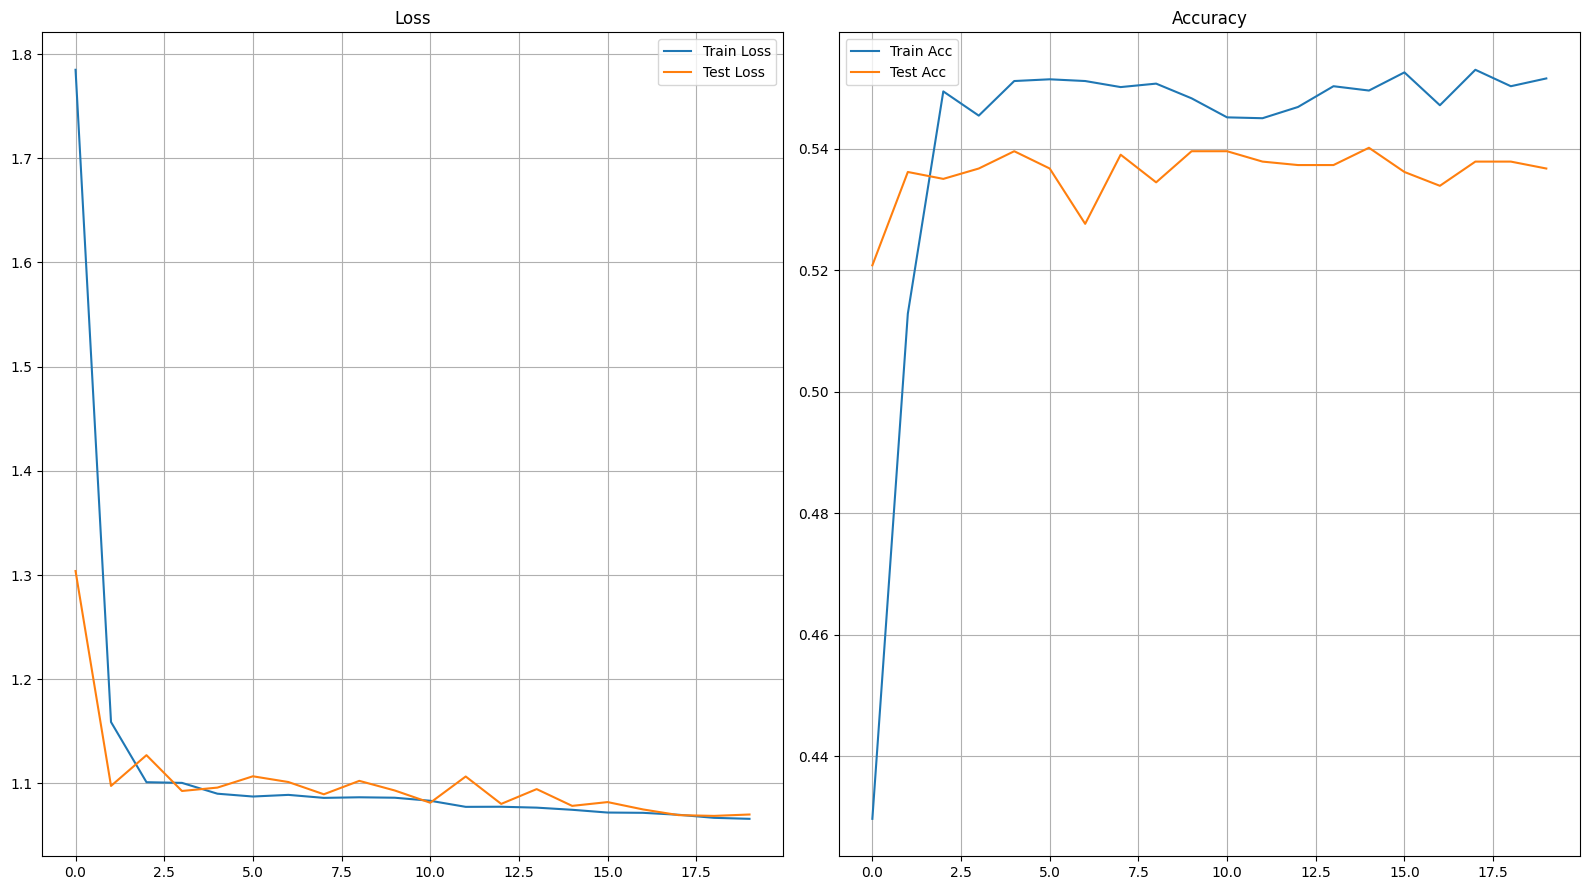

In [13]:
plot_training_history(metric_vit)